# 1-1 Deutsch-Jozsa problem

입력값을 비트열로 받고 출력값이 0 또는 1인 어떤 boolean 함수 f가 있다

이 함수가 모든 출력값이 0 이거나 1인 balanced 함수인지 절반의 경우로 0 또는 1인 constant 함수인지 결정해야 한다

Deutsch-Jozsa problem은 single bit Deutsch problem을 n-bit로 확장한 버전이다

# 1-2 classical solution

고전적으로 두가지 질문으로 함수를 결정할 수 있다

입력값으로 0만 넣었을 때 0이 나오고 입력값 중 하나를 1로 바꿨을 때 1을 얻을 수 있다면 balanced 함수이다

constant 함수로 확정짓기 위해서 확률이 절반인지 확인하기 위해 같은 짓을 계속 반복해야 한다

input이 2^n개라면 2^(n-1)+1의 연산을 해야한다

# 1-3 quantum solution

|x>|y> 상태를 |x>|y⊕f(x)>로 매핑하는 함수 f를 구성하는데 ⊕는 addition modulo 2다

알고리즘의 순서를 살펴보면

1) 두 양자 레지스터를 준비하는데 첫번째는 |0>으로 초기화 된 n-qubit 레지스터고 두번째는 |1>로 초기화된 1qubit 레지스터다

2) 각 큐빗에 H게이트를 적용시켜 중첩상태로 만든다

3) 위에서 만든 함수를 적용시킨다

4) 첫번째 게이트에 H게이트를 적용시킨다

5) 첫번째 레지스터를 관측한다    
만약 값이 1이라면 constant 함수고 0이라면 balanced 함수

# 1-4 작동 원리

1) constant oracle

oracle이 상수일 때 input큐빗에는 아무런 효과가 없고 쿼리를 적용하기 전과 후 양자의 상태가 같다

2) balanced oracle

2번째 단계 이후 input레지스터는 모든 상태의 확률이 동등한 중첩상태가 된다   
이 때 oracle이 balance라면 절반에 phase kickback이 일어난다

# 2 작동 예시

예) 2 큐빗 balance 함수 

f(x0,x1) = x0 ⊕ x1
f(0,0) = 0
f(0,1) = 1
f(1,0) = 1
f(1,1) = 0

# 3 quantum oracle 만들기

constant function의 경우   
f(x) = 0 -> register 2에 I 게이트 적용   
f(x) = 1 -> register 2에 X 게이트 적용

balance function의 경우 다양한 회로를 만들 수 있다   
방법 중 하나는 1번째 레지스터에서 2번째 레지스터로 CNOT 게이트를 거는 것이다

output이 0이 되는 input = 000,011,101,110이고 나머지는 1이 된다



# 4 qiskit 

In [2]:
import numpy as np

from qiskit import IBMQ,Aer
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, transpile

from qiskit.visualization import plot_histogram

/opt/conda/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


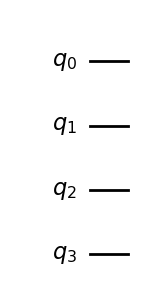

In [3]:
n = 3

const_oracle = QuantumCircuit(n+1)

# constant는 input에 영향이 없어서 output값을 1과 0중 랜덤으로 지정
output = np.random.randint(2)
if output == 1:
    const_oracle.x(n)
const_oracle.draw()

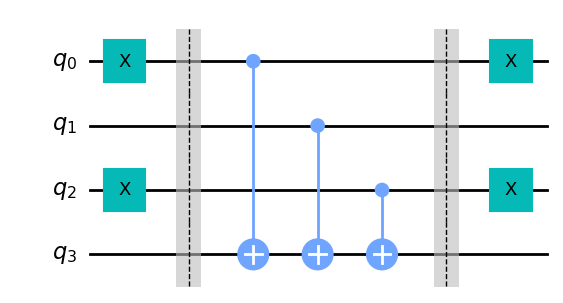

In [8]:
balanced_oracle = QuantumCircuit(n+1)
#1,3번째 큐빗에 x게이트를 주기위한 바이너리 스트링
b_str = "101"

for qubit in range(len(b_str)):
    if b_str[qubit] == '1':
        balanced_oracle.x(qubit)

balanced_oracle.barrier()
# 레지스터에 CNOT 걸기
for qubit in range(n):
    balanced_oracle.cx(qubit,n)
    
balanced_oracle.barrier()

for qubit in range(len(b_str)):
    if b_str[qubit] == '1':
        balanced_oracle.x(qubit)
        
balanced_oracle.draw()

#x 게이트를 걸었돈 곳에 다시 x게이트를 검

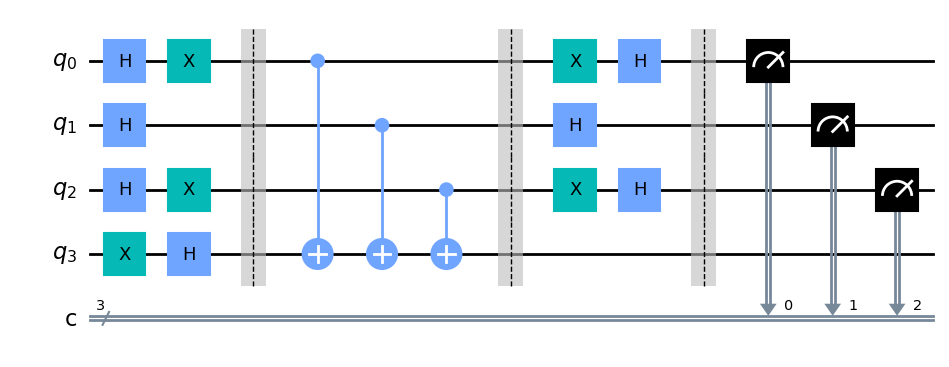

In [11]:
# 회로 합치기

dj_circuit = QuantumCircuit(n+1, n)

#initialize
for qubit in range(n):
    dj_circuit.h(qubit)

dj_circuit.x(n)
dj_circuit.h(n)

# add balance oracle
dj_circuit = dj_circuit.compose(balanced_oracle)

#Hgate를 적용한 뒤 측정하기
for qubit in range(n):
    dj_circuit.h(qubit)
dj_circuit.barrier()

for i in range (n):
    dj_circuit.measure(i,i)
    
dj_circuit.draw()

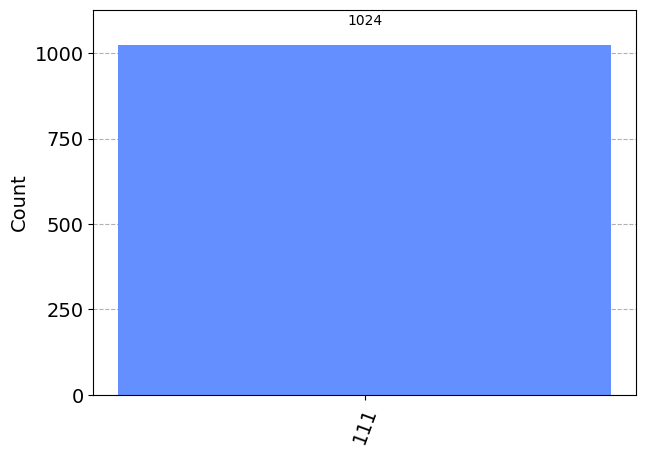

In [14]:
aer_sim = Aer.get_backend('aer_simulator')
results = aer_sim.run(dj_circuit).result()
ans = results.get_counts()
plot_histogram(ans)

In [15]:
# 000 은 측정 가능성이 0임을 확인
assert ans.get('000',0) == 0

# 회로 일반화


In [16]:
def dj_oracle(case,n):
    #양자 회로를 리턴해주는 함수
    #n은 input의 크기
    oracle_qc = QuantumCircuit(n+1)
    
    if case == "balanced":
        #어떤 CNOT을 수행할지 결정할 랜덤한 수 생성
        b = np.random.randint(1,2**n)
        # b 를 길이 n의 바이너리 스트링으로 만듬
        b_str = format(b,'0'+str(n)+'b')
        #숫자가 1이라면 x게이트 적용
        for qubit in range(len(b_str)):
            if b_str[qubit] == '1':
                oracle_qc.x(qubit)
        #output을 타킷으로 각 큐빗에 CNOT 적용
        for qubit in range(n):
            oracle_qc.cx(qubit, n)
        #마지막 X 게이트 적용
        for qubit in range(len(b_str)):
            if b_str[qubit] == '1':
                oracle_qc.x(qubit)
    if case == "constant":
        output = np.random.randint(2)
        if output == 1:
            oracle_qc.x(n)
    oracle_gate = oracle_qc.to_gate()
    oracle_gate.name = "Oracle"
    return oracle_gate

In [18]:
#위의 게이트를 사용하는 알고리즘 생성
def dj_algorithm(oracle,n):
    dj_circuit = QuantumCircuit(n+1,n)
    #output 큐빗 설정
    dj_circuit.x(n)
    dj_circuit.h(n)
    #input 설정
    for qubit in range(n):
        dj_circuit.h(qubit)
    
    dj_circuit.append(oracle,range(n+1))
    #H게이트 걸고 측정
    for qubit in range(n):
        dj_circuit.h(qubit)
    
    for i in range(n):
        dj_circuit.measure(i, i)
    
    return dj_circuit

/opt/conda/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


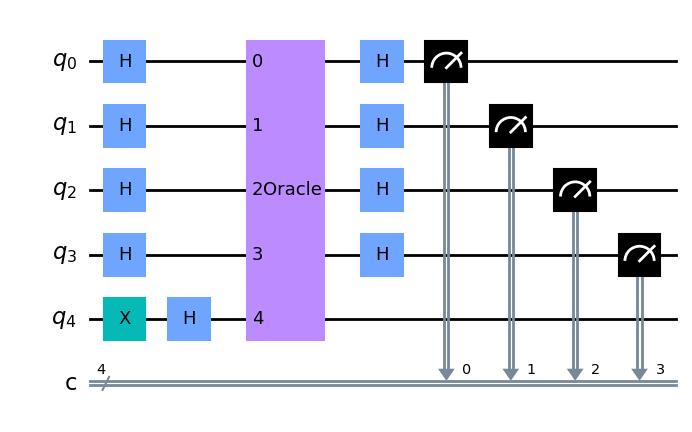

In [19]:
n = 4
oracle_gate = dj_oracle('balanced', n)
dj_circuit = dj_algorithm(oracle_gate, n)
dj_circuit.draw()